In [2]:
import os
os.chdir("..")  # or os.chdir("..\\..") depending on notebook location


In [16]:
# =========================
# CELL 1 — Imports & loading
# =========================

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 5)

# Hardcoded paths based on our project structure
train_raw_path      = "data/raw/train.csv"
train_resampled_path = "data/processed/train_1min.csv"
test_resampled_path  = "data/processed/test_1min.csv"

# Load raw train
raw = pd.read_csv(train_raw_path)
raw["datetime"] = pd.to_datetime(raw["datetime"], utc=True)

# Load resampled train
res = pd.read_csv(train_resampled_path)
res["datetime"] = pd.to_datetime(res["datetime"], utc=True)

# Pick a home to inspect
HOME_ID = "home_2"
raw_home = raw[raw["home_id"] == HOME_ID].sort_values("datetime")
res_home = res[res["home_id"] == HOME_ID].sort_values("datetime")

raw_home.head(), res_home.head()

(                        datetime   power  fridge home_id
 579900 2013-02-17 16:17:34+00:00   340.0    11.0  home_2
 579901 2013-02-17 16:30:00+00:00   401.0    11.0  home_2
 579902 2013-02-17 16:45:00+00:00   535.0    11.0  home_2
 579903 2013-02-17 16:55:54+00:00  3432.0    11.0  home_2
 579904 2013-02-17 16:58:29+00:00   457.0    11.0  home_2,
                          datetime  power  fridge home_id
 1132308 2013-02-17 16:17:00+00:00    NaN     NaN  home_2
 1132309 2013-02-17 16:18:00+00:00  340.0    11.0  home_2
 1132310 2013-02-17 16:19:00+00:00  340.0    11.0  home_2
 1132311 2013-02-17 16:20:00+00:00  340.0    11.0  home_2
 1132312 2013-02-17 16:21:00+00:00  340.0    11.0  home_2)

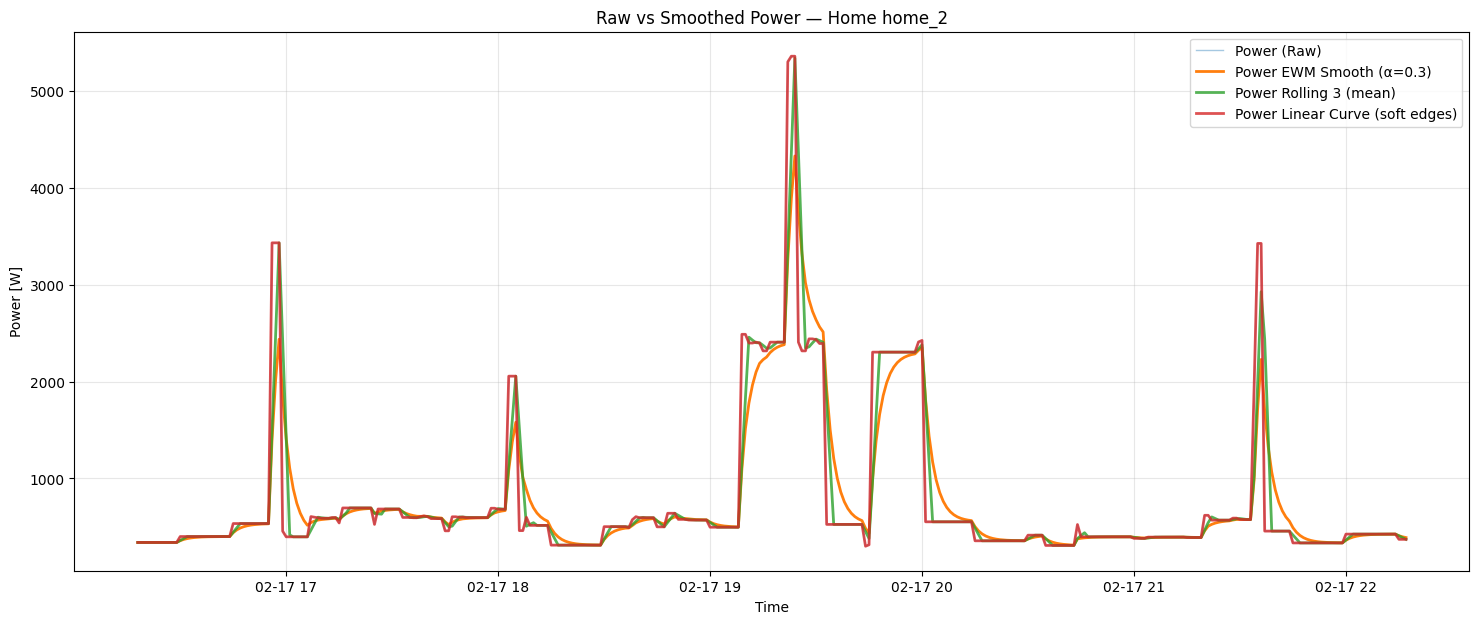

In [20]:
# ============================================
# SMOOTHED POWER VISUALIZATION (NOTEBOOK ONLY)
# ============================================

import pandas as pd
import matplotlib.pyplot as plt

# Make sure res_home is already defined, otherwise re-load:
# res = pd.read_csv("data/processed/train_1min.csv")
# res["datetime"] = pd.to_datetime(res["datetime"], utc=True)
# HOME_ID = "home_1"
# res_home = res[res["home_id"] == HOME_ID].sort_values("datetime")

df = res_home.copy()

# 1) Exponential smoothing (best for rounded edges)
df["power_ewm"] = df["power"].ewm(alpha=0.3, adjust=False).mean()

# 2) Rolling mean (very light smoothing)
df["power_roll3"] = df["power"].rolling(window=3, min_periods=1).mean()

# 3) Light interpolation to soften corners (limit 2 prevents excessive smoothing)
df["power_curve"] = df["power"].interpolate(method="linear", limit=2, limit_direction="forward")

# 4) Plot window (choose any)
start = df["datetime"].min()
end   = start + pd.Timedelta(hours=6)   # show first 6 hours
win = df[(df["datetime"] >= start) & (df["datetime"] <= end)]

# PLOT
plt.figure(figsize=(18, 7))

plt.plot(win["datetime"], win["power"], label="Power (Raw)", alpha=0.4, linewidth=1)
plt.plot(win["datetime"], win["power_ewm"], label="Power EWM Smooth (α=0.3)", linewidth=2)
plt.plot(win["datetime"], win["power_roll3"], label="Power Rolling 3 (mean)", linewidth=2, alpha=0.8)
plt.plot(win["datetime"], win["power_curve"], label="Power Linear Curve (soft edges)", linewidth=2, alpha=0.8)

plt.title(f"Raw vs Smoothed Power — Home {HOME_ID}")
plt.xlabel("Time")
plt.ylabel("Power [W]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


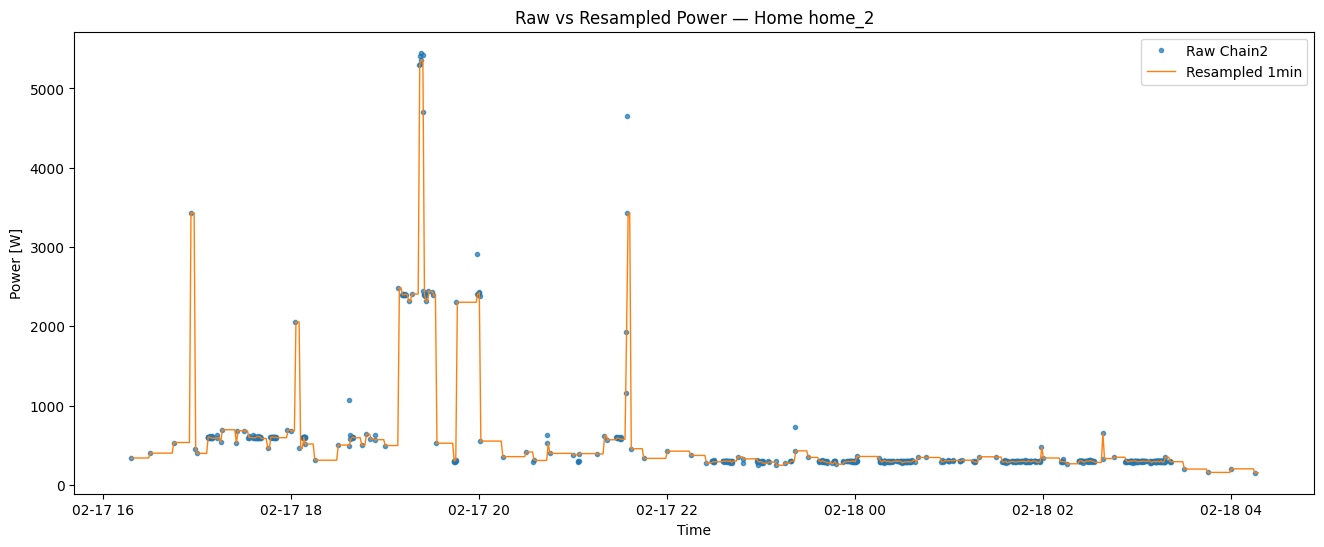

In [17]:
# =========================
# CELL 2 — Raw vs resampled (sanity check)
# =========================

# Take a 12-hour window from the start of this home
start = raw_home["datetime"].min()
end   = start + pd.Timedelta(hours=12)

raw_win = raw_home[(raw_home["datetime"] >= start) & (raw_home["datetime"] <= end)]
res_win = res_home[(res_home["datetime"] >= start) & (res_home["datetime"] <= end)]

plt.figure(figsize=(16, 6))
plt.plot(raw_win["datetime"], raw_win["power"], ".", label="Raw Chain2", alpha=0.7)
plt.plot(res_win["datetime"], res_win["power"], "-", label="Resampled 1min", linewidth=1)
plt.legend()
plt.title(f"Raw vs Resampled Power — Home {HOME_ID}")
plt.xlabel("Time")
plt.ylabel("Power [W]")
plt.show()


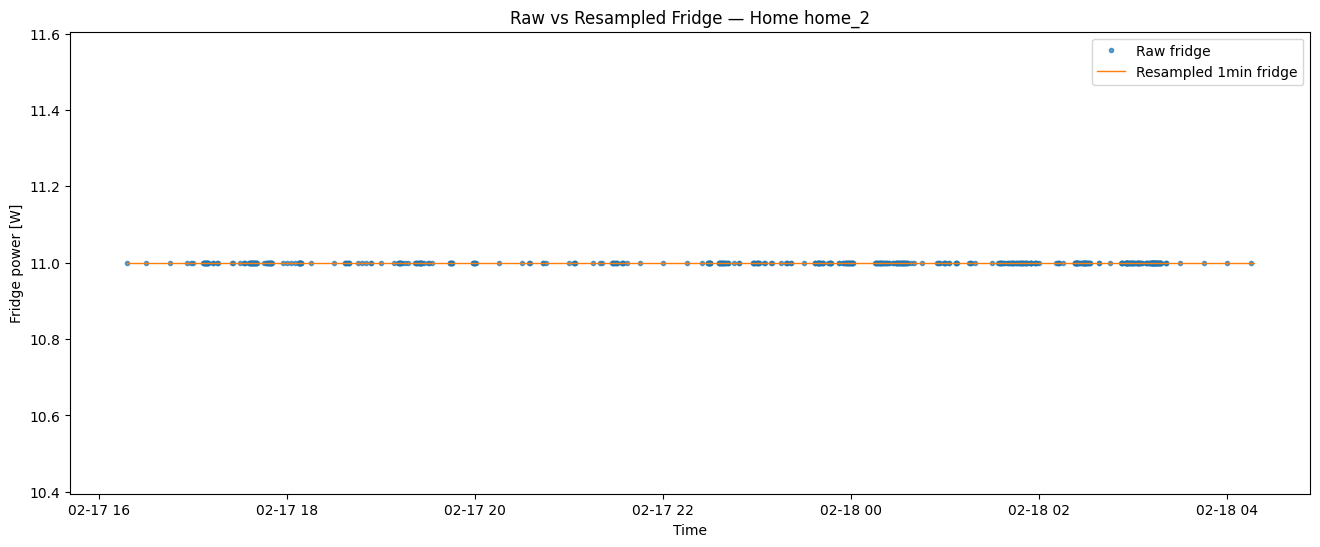

In [18]:
# =========================
# Raw vs Resampled Fridge (same window as power)
# =========================

# pick a time window (here: first 12h of this home)
start = raw_home["datetime"].min()
end   = start + pd.Timedelta(hours=12)

raw_win = raw_home[(raw_home["datetime"] >= start) & (raw_home["datetime"] <= end)]
res_win = res_home[(res_home["datetime"] >= start) & (res_home["datetime"] <= end)]

plt.figure(figsize=(16, 6))

# raw fridge (original Chain2 samples)
plt.plot(raw_win["datetime"], raw_win["fridge"], ".", label="Raw fridge", alpha=0.7)

# resampled fridge (1-minute, cleaned)
plt.plot(res_win["datetime"], res_win["fridge"], "-", label="Resampled 1min fridge", linewidth=1)

plt.legend()
plt.title(f"Raw vs Resampled Fridge — Home {HOME_ID}")
plt.xlabel("Time")
plt.ylabel("Fridge power [W]")
plt.show()


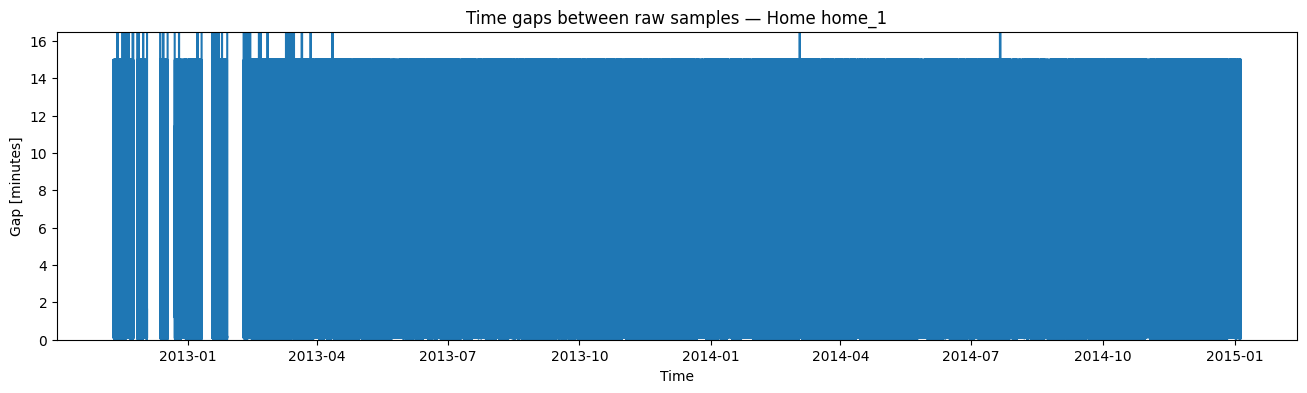

In [8]:
# =========================
# CELL 3 — Gaps in raw Chain2 data
# =========================

raw_home = raw_home.sort_values("datetime")
raw_home["gap_minutes"] = raw_home["datetime"].diff().dt.total_seconds() / 60

plt.figure(figsize=(16, 4))
plt.plot(raw_home["datetime"], raw_home["gap_minutes"])
plt.title(f"Time gaps between raw samples — Home {HOME_ID}")
plt.xlabel("Time")
plt.ylabel("Gap [minutes]")
# Optional: cap y-axis to focus on typical gaps
plt.ylim(0, raw_home["gap_minutes"].quantile(0.99) * 1.1)
plt.show()


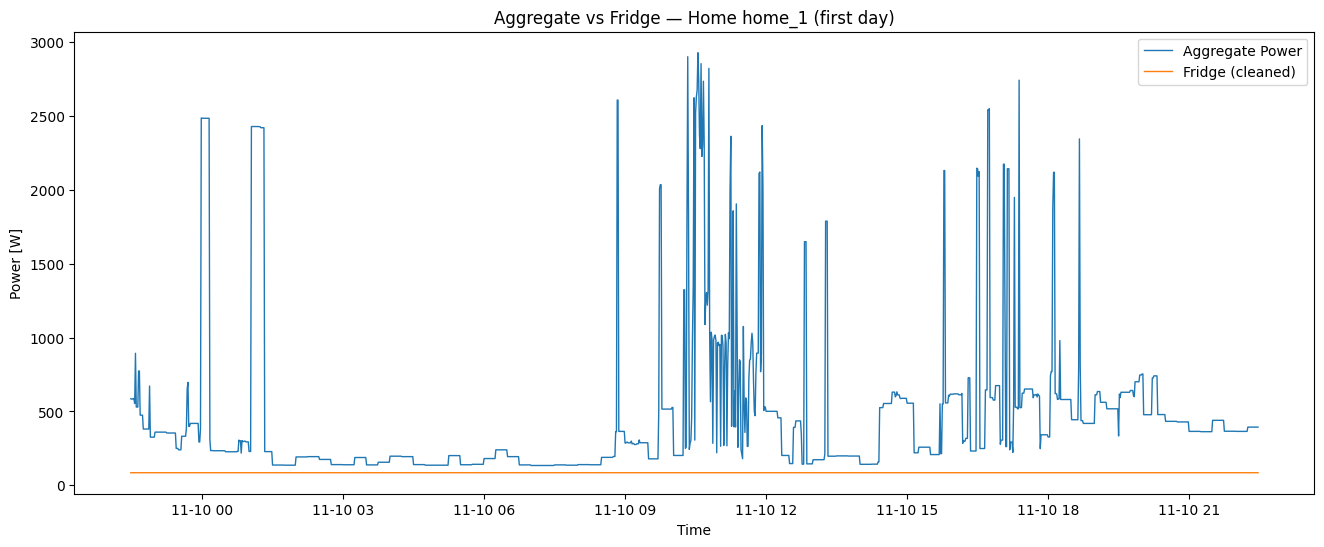

In [ ]:
# =========================
# CELL 4 — Aggregate vs fridge (after cleaning) on 1 day
# =========================

start_day = res_home["datetime"].min()
end_day   = start_day + pd.Timedelta(days=1)

day_win = res_home[(res_home["datetime"] >= start_day) & (res_home["datetime"] <= end_day)]

plt.figure(figsize=(16, 6))
plt.plot(day_win["datetime"], day_win["power"], label="Aggregate Power", linewidth=1)
if "fridge" in day_win.columns:
    plt.plot(day_win["datetime"], day_win["fridge"], label="Fridge (cleaned)", linewidth=1)
plt.legend()
plt.title(f"Aggregate vs Fridge — Home {HOME_ID} (first day)")
plt.xlabel("Time")
plt.ylabel("Power [W]")
plt.show()

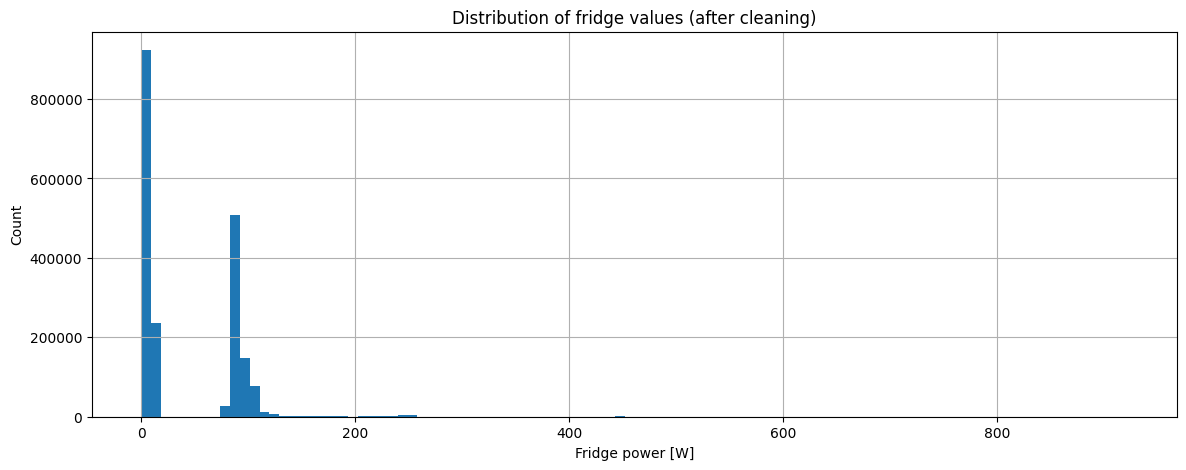

In [10]:
# =========================
# CELL 5 — Fridge histogram (after cleaning)
# =========================

if "fridge" in res.columns:
    res["fridge"].hist(bins=100)
    plt.title("Distribution of fridge values (after cleaning)")
    plt.xlabel("Fridge power [W]")
    plt.ylabel("Count")
    plt.show()
else:
    print("No 'fridge' column in resampled data (are you sure this is train_1min.csv?).")


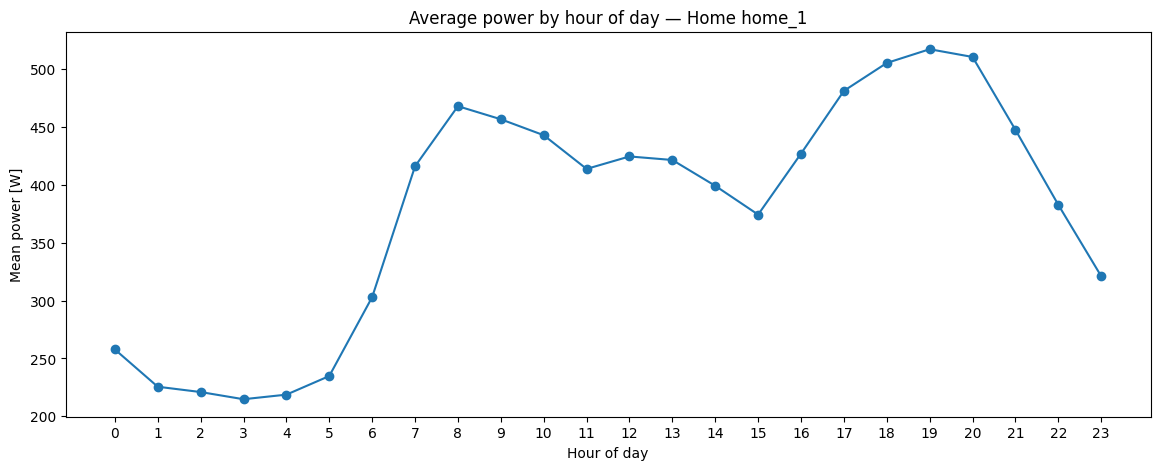

In [11]:
# =========================
# CELL 6 — Average daily pattern by hour
# =========================

df_hour = res_home.copy()
df_hour["hour"] = df_hour["datetime"].dt.hour

df_hour.groupby("hour")["power"].mean().plot(marker="o")
plt.title(f"Average power by hour of day — Home {HOME_ID}")
plt.xlabel("Hour of day")
plt.ylabel("Mean power [W]")
plt.xticks(range(0, 24))
plt.show()


<Axes: xlabel='hour'>

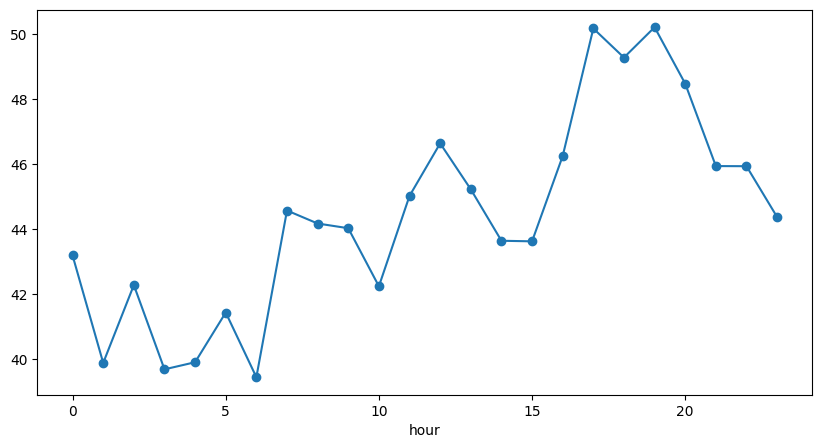

In [15]:
df_hour = res_home.copy()
df_hour["hour"] = df_hour["datetime"].dt.hour

counts = df_hour.groupby("hour")["fridge"].count()

# Only keep hours with at least e.g. 200 samples
valid_hours = counts[counts > 200].index

df_hour[df_hour["hour"].isin(valid_hours)] \
    .groupby("hour")["fridge"] \
    .mean() \
    .plot(marker="o", figsize=(10,5))
